In [1]:
import torch

from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import ignite.metrics as ig
from torch.nn.utils.rnn import pad_sequence


import torchvision
from torchvision import datasets, transforms
import csv

from matplotlib import pyplot as plt
from IPython.display import clear_output
import math
import os
from PIL import Image
import gc
import librosa

import time

In [2]:
batch_size = 32

In [3]:
file_path = 'target/targets.tsv'
name_number = []
with open(file_path, 'r', newline='', encoding='utf-8') as file:
    tsv_reader = csv.reader(file, delimiter='\t')
    for row in tsv_reader:
        name = row[0]
        value = int(row[1])
        name_number.append((name, value))

In [4]:
def load_wav_files_from_folder(folder_path):
    wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    wav_data = []
    wav_gender = []
    for wav_file in wav_files:
        j = -1
        for i in range(len(name_number)):
            if wav_file == name_number[i][0]  + '.wav':
                j = i
                break
        file_path = os.path.join(folder_path, wav_file)
        y, sr = librosa.load(file_path, sr=None)
        wav_data.append((y, sr))
        wav_gender.append(name_number[j][1])

    return wav_data, wav_gender

def compute_melspectrograms(wav_data, n_mels=128, fmax=8000):
    melspectrograms = []
    i = 0
    for y, sr in wav_data:
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
        S_dB = librosa.power_to_db(S, ref=np.max)
        melspectrograms.append(S_dB)
        if i % 1000 == 0:
            print(i)
        i += 1
    return melspectrograms

folder_path = 'train/train'
wav_data, wav_gender = load_wav_files_from_folder(folder_path)
melspectrograms = compute_melspectrograms(wav_data)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [22]:
print(melspectrograms[1])

[[-80.       -80.       -80.       ... -63.644783 -63.241547 -59.449112]
 [-80.       -80.       -80.       ... -55.63958  -48.61888  -47.3129  ]
 [-80.       -80.       -80.       ... -53.52868  -49.062286 -49.005722]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]


1


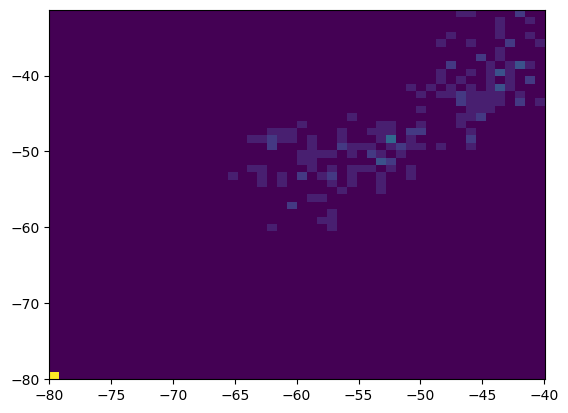

In [21]:
i = 11
print(name_number[i][1])
plt.hist2d(melspectrograms[i][0], melspectrograms[i][1], bins = 50)
plt.show()

0


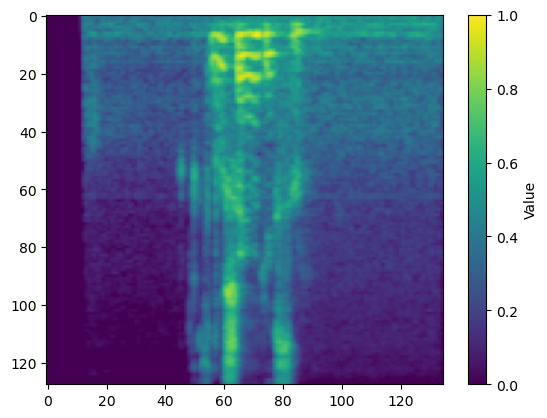

In [115]:
i = 26
print(name_number[i][1])
plt.imshow((80 + melspectrograms[i])/80, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')

In [53]:
max_len = -1
for i in range(len(melspectrograms)):
    if max_len < melspectrograms[i].shape[1]: #print(melspectrograms[i].shape[1])
        max_len = melspectrograms[i].shape[1]
        print(i)
print(max_len)

0
1
5
31
68
134
5019
9441
386


In [5]:
normalized_melspectrograms = []
target_shape = (128, 400)
for spectogram in melspectrograms:
    new_array = np.full(target_shape, -80)
    original_shape = spectogram.shape
    new_array[:, -original_shape[1]:] = spectogram
    normalized_melspectrograms.append(new_array)

0


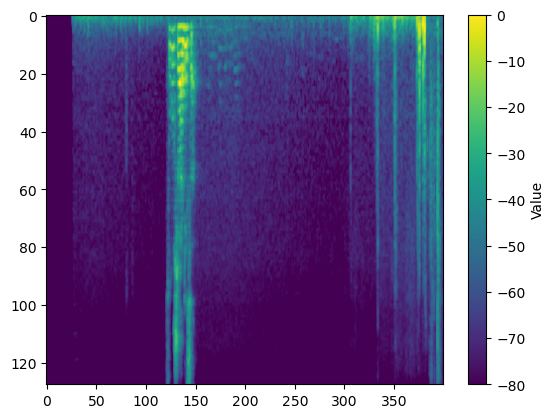

In [54]:
i = 9441
print(name_number[i][1])
plt.imshow(normalized_melspectrograms[i], cmap='viridis', aspect='auto')
plt.colorbar(label='Value')

In [116]:
class SoundsDataset(Dataset):
    def __init__(self, x_arr, y_arr):
        self.x = x_arr
        self.y = y_arr
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = (self.x[idx] + 80)/80
        y = self.y[idx]
        return x, y

In [117]:
train_size = int(len(melspectrograms) * 0.8)
val_size = len(melspectrograms) - train_size

In [118]:
from torch.nn.utils.rnn import pad_sequence

def pad_2d(tensor, target_shape):
    padding = (0, target_shape[1] - tensor.shape[1], 0, target_shape[0] - tensor.shape[0])
    return torch.nn.functional.pad(tensor, padding, mode='constant', value=0)

def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = [torch.tensor(x) for x in xs]
    ys = torch.tensor(ys)
    
    max_shape = (max([x.shape[0] for x in xs]), max([x.shape[1] for x in xs]))
    xs_padded = torch.stack([pad_2d(x, max_shape) for x in xs])
    
    return xs_padded, ys

In [119]:
trainer_data = SoundsDataset(normalized_melspectrograms, wav_gender)

In [120]:
train_data, val_data = torch.utils.data.random_split(trainer_data, [train_size, val_size])

In [121]:
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False, collate_fn=collate_fn)

In [9]:
class CNNM(nn.Module):
    def __init__(self):
        super().__init__()
        self.mp = nn.MaxPool2d(2)
        self.flt = nn.Flatten()
        self.ln = nn.LayerNorm((1, 128, 400))
        self.b1 = nn.BatchNorm2d(1)
        self.c1 = nn.Conv2d(in_channels = 1, out_channels = 9, kernel_size = 3) #126 398 -> 63 199
        self.b2 = nn.BatchNorm2d(9)
        self.c2 = nn.Conv2d(in_channels = 9, out_channels = 18, kernel_size = 2) #62 198 -> 31 99
        self.b3 = nn.BatchNorm2d(18)
        self.c3 = nn.Conv2d(in_channels = 18, out_channels = 36, kernel_size = 4) #28 -> 96 -> 14 48
        self.b4 = nn.BatchNorm2d(36)
        self.c4 = nn.Conv2d(in_channels = 36, out_channels = 36, kernel_size = 3, padding = 1) #14 
        self.c5 = nn.Conv2d(in_channels = 36, out_channels = 36, kernel_size = 3, padding = 1)
        self.c6 = nn.Conv2d(in_channels = 36, out_channels = 18, kernel_size = 3, padding = 1)

        self.l1 = nn.Linear(14 * 48 * 18, 3000)
        self.bl1 = nn.BatchNorm1d(3000)
        self.d1 = nn.Dropout(p=0.4)
        self.l2 = nn.Linear(3000, 2000)
        self.bl2 = nn.BatchNorm1d(2000)
        self.d2 = nn.Dropout(p=0.4)
        self.l3 = nn.Linear(2000, 500)
        self.bl3 = nn.BatchNorm1d(500)
        self.d3 = nn.Dropout(p=0.4)
        self.l4 = nn.Linear(500, 100)
        self.bl4 = nn.BatchNorm1d(100)
        self.d4 = nn.Dropout(p=0.4)
        self.l5 = nn.Linear(100, 15)
        self.d5 = nn.Dropout(p=0.4)
        self.l6 = nn.Linear(15, 2)
        self.d6 = nn.Dropout(p=0.4)
        self.f1 = nn.Softmax(dim = 1)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, 128, 400)
        x = self.b1(x)
        x = self.ln(x)
        x = F.relu(self.c1(x))
        x = self.mp(x)
        x = self.b2(x)
        x = F.relu(self.c2(x))
        x = self.mp(x)
        x = self.b3(x)
        x = F.relu(self.c3(x))
        x = self.mp(x)
        x = self.b4(x)
        x = F.relu(self.c4(x))
        x = F.relu(self.c5(x))
        x = F.relu(self.c6(x))
        x = self.flt(x)
        
        x = F.relu(self.l1(x))
        x = self.d1(x)
        x = F.relu(self.l2(x))
        x = self.d2(x)
        x = F.relu(self.l3(x))
        x = self.d3(x)
        x = F.relu(self.l4(x))
        x = self.d4(x)
        x = F.relu(self.l5(x))
        x = self.d5(x)
        x = F.relu(self.l6(x))
        x = self.d6(x)
        #x = self.f1(x)

        return x

In [176]:
best_score = 98.4

In [177]:
def model_eval(model, train, val, loss_fn):
    model.eval()
    global best_score
    with torch.no_grad():
        losses = []
        num_correct = 0
        len_val = 0
        for batch in val:
            x, y = batch
            len_val += len(y)
            y_pred = model(x.to(torch.float32).to(device))
            losses.append(loss_fn(y_pred.float(), y.to(device)).item())
            y_pred_real = torch.argmax(y_pred, dim = 1).cpu()
            num_correct += torch.sum(y_pred_real == y)
        print(f'Точность на тестовой выборке: {round(float(num_correct) / len_val * 100, 3)} %, loss: {np.mean(losses)}')
        if round(float(num_correct)) / len_val * 100 > best_score:
            torch.save(model.state_dict(), 'good_model.pth')
            best_score = round(float(num_correct)) / len_val * 100
        losses = []
        num_correct = 0
        len_train = 0
        for batch in train:
            x, y = batch
            len_train += len(y)
            y_pred = model(x.to(torch.float32).to(device))
            losses.append(loss_fn(y_pred.float(), y.to(device)).item())
            y_pred_real = torch.argmax(y_pred, dim = 1).cpu()
            num_correct += torch.sum(y_pred_real == y)
        print(f'Точность на обучаемой выборке: {round(float(num_correct) / len_train * 100, 3)} %, loss: {np.mean(losses)}')
    model.train()

In [153]:
md = CNNM()
tensor = torch.randn(2, 128, 400)
#print(tensor.shape)
output_tensor = md(tensor)
print(output_tensor)

tensor([[0.3334, 0.0000],
        [0.3519, 0.0000]], grad_fn=<MulBackward0>)


In [11]:
device = torch.device('cuda')

In [160]:
model = CNNM().to(device)
model.train()

CNNM(
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flt): Flatten(start_dim=1, end_dim=-1)
  (ln): LayerNorm((1, 128, 400), eps=1e-05, elementwise_affine=True)
  (b1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c1): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1))
  (b2): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c2): Conv2d(9, 18, kernel_size=(2, 2), stride=(1, 1))
  (b3): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(18, 36, kernel_size=(4, 4), stride=(1, 1))
  (b4): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4): Conv2d(36, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c5): Conv2d(36, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c6): Conv2d(36, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l1): Linear(in_features=12096, out_features=3000, bias

In [179]:
optimiser = torch.optim.Adam(model.parameters(), lr = 2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [130]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs')

In [87]:
save_interval = 30

In [131]:
iterations = 0

In [181]:
start_time = time.time()
eval_time = time.time()
for i in range(100):
  print("epoch:", i + 1)
  for j, batch in enumerate(train_loader):
      x, y = batch
      optimiser.zero_grad()
      y_pred = model(x.to(torch.float32).to(device))
      loss = loss_fn(y_pred, y.to(device))
      
      if time.time() - eval_time > save_interval:
        eval_time += save_interval
        torch.save(model.state_dict(), 'model.pth')
        model_eval(model, train_loader, val_loader, loss_fn)
        x_c = x.to('cpu')
        y_c = y.to('cpu')
        y_pred_c = y_pred.to('cpu')
        s_time = time.time()
        print("Прошло времени: ", time.time() - start_time, 'c')
    
      iterations += batch_size
      writer.add_scalar("Loss", loss, iterations)
      loss.backward()
      optimiser.step()
      #for name, param in model.named_parameters():
            #print(param.grad)
  #model.train(False)
  if (i + 1) % 2 == 0:
    s_time = time.time()
    print("Прошло времени: ", time.time() - start_time, 'c')
print("Время затраченное на обучение:", time.time() - start_time - eval_time)

epoch: 1
epoch: 2
Точность на тестовой выборке: 98.242 %, loss: 0.29846466736950983
Точность на обучаемой выборке: 100.0 %, loss: 6.55159273738152e-06
Прошло времени:  37.28906869888306 c
Прошло времени:  38.2907190322876 c
epoch: 3
epoch: 4
Точность на тестовой выборке: 98.35 %, loss: 0.3076942537353823
Точность на обучаемой выборке: 100.0 %, loss: 7.851451539613423e-08
Прошло времени:  67.33618378639221 c
Прошло времени:  76.58887720108032 c
epoch: 5
Точность на тестовой выборке: 98.494 %, loss: 0.3080092829958816
Точность на обучаемой выборке: 100.0 %, loss: 3.469490547114572e-08
Прошло времени:  97.24088835716248 c
epoch: 6
Прошло времени:  114.38547682762146 c
epoch: 7
Точность на тестовой выборке: 98.314 %, loss: 0.33885092796683214
Точность на обучаемой выборке: 100.0 %, loss: 4.6254720330671164e-08
Прошло времени:  126.89234614372253 c
epoch: 8
Точность на тестовой выборке: 98.207 %, loss: 0.32809301801237284
Точность на обучаемой выборке: 100.0 %, loss: 2.909547360962078e-05
П

KeyboardInterrupt: 

In [35]:
def load_wav_files_from_folder(folder_path):
    wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    wav_data = []
    wav_name = []
    for wav_file in wav_files:
        file_path = os.path.join(folder_path, wav_file)
        y, sr = librosa.load(file_path, sr=None)
        wav_data.append((y, sr))
        wav_name.append(wav_file)

    return wav_data, wav_name

def compute_melspectrograms(wav_data, n_mels=128, fmax=8000):
    melspectrograms = []
    i = 0
    for y, sr in wav_data:
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
        S_dB = librosa.power_to_db(S, ref=np.max)
        melspectrograms.append(S_dB)
        if i % 1000 == 0:
            print(i)
        i += 1
    return melspectrograms
folder_path = 'test'
wav_data, wav_name = load_wav_files_from_folder(folder_path)

melspectrograms = compute_melspectrograms(wav_data)
wav_name = [name[:-4] for name in wav_name]

0
1000
2000
3000


In [4]:
def pad_2d(tensor, target_shape):
    padding = (0, target_shape[1] - tensor.shape[1], 0, target_shape[0] - tensor.shape[0])
    return torch.nn.functional.pad(tensor, padding, mode='constant', value=0)

def collate_fn(batch):
    xs, names = zip(*batch)
    xs = [torch.tensor(x) for x in xs]
    
    max_shape = (max([x.shape[0] for x in xs]), max([x.shape[1] for x in xs]))
    xs_padded = [F.pad(x, (0, max_shape[1] - x.shape[1], 0, max_shape[0] - x.shape[0])) for x in xs]
    xs_padded = torch.stack(xs_padded)
    
    return xs_padded, names

In [36]:
normalized_melspectrograms = []
target_shape = (128, 400)
for spectogram in melspectrograms:
    new_array = np.full(target_shape, -80)
    original_shape = spectogram.shape
    new_array[:, -original_shape[1]:] = spectogram
    normalized_melspectrograms.append(new_array)


In [37]:
class SoundsDataset(Dataset):
    def __init__(self, x_arr, name):
        self.x = x_arr
        self.name = name
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = (self.x[idx] + 80)/80
        name = self.name[idx]
        return x, name

In [38]:
test_data = SoundsDataset(normalized_melspectrograms, wav_name)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False, collate_fn=collate_fn)

In [39]:
model = CNNM().to(device)
model.eval()

CNNM(
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flt): Flatten(start_dim=1, end_dim=-1)
  (ln): LayerNorm((1, 128, 400), eps=1e-05, elementwise_affine=True)
  (b1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c1): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1))
  (b2): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c2): Conv2d(9, 18, kernel_size=(2, 2), stride=(1, 1))
  (b3): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(18, 36, kernel_size=(4, 4), stride=(1, 1))
  (b4): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4): Conv2d(36, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c5): Conv2d(36, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c6): Conv2d(36, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l1): Linear(in_features=12096, out_features=3000, bias

In [40]:
model.load_state_dict(torch.load('good_model98_49.pth'))

<All keys matched successfully>

In [62]:
data = []
with torch.no_grad():
    for batch in test_loader:
        x, name = batch
        y_pred = model(x.to(torch.float32).to(device))
        #print(y_pred)
        for i in range(len(x)):
            pred = torch.argmax(y_pred[i])
            data.append((pred.cpu().detach().item(), name[i]))

In [69]:
data = [(name, number) for number, name in data]

In [ ]:
import csv
filename = "answers.tsv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file, delimiter='\t')
    for row in data:
        writer.writerow(row)

In [ ]:
with open('target/targets.tsv', newline='', encoding='utf-8') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
        print(row)